In [1]:
import meshio
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

In [2]:
def find_lines_through_origin(points, min_points=10, tolerance=1e-4):
    # Extract x and y coordinates
    xy_points = points[:, :2]
    
    # Calculate angles with respect to the origin
    angles = np.arctan2(xy_points[:, 1], xy_points[:, 0])
    
    # Round angles to the specified tolerance
    rounded_angles = np.round(angles / tolerance) * tolerance
    
    # Count occurrences of each rounded angle
    unique_angles, counts = np.unique(rounded_angles, return_counts=True)
    
    # Find angles with at least min_points points
    result_angles = unique_angles[counts >= min_points]
    
    # Create a list of lines (angles) with the corresponding points
    lines_with_points = [(angle, xy_points[rounded_angles == angle]) for angle in result_angles]
    
    return lines_with_points

def reflect_points(points, angle):
    # Construct the 3D reflection matrix for the given angle
    reflection_matrix = np.array([
        [np.cos(2 * angle), np.sin(2 * angle), 0],
        [np.sin(2 * angle), -np.cos(2 * angle), 0],
        [0, 0, 1]
    ])
    
    # Apply the reflection matrix to each point
    reflected_points = np.dot(points, reflection_matrix.T)
    
    return reflected_points

def rotate_points(points, angle):
    # construct 3d rotation matrix for the given angle
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])

    # apply the rotation matrix
    rotated_points = np.dot(points, rotation_matrix.T)

    return rotated_points

In [3]:
points, cells = meshio.xdmf.TimeSeriesReader("sim003.xdmf").read_points_cells()

lines = find_lines_through_origin(points)

# Get the first line's angle
first_angle = np.min([line[0] for line in lines])

# Reflect points across the first line's axis
mirrored_points = reflect_points(points, first_angle)

third_points_0 = np.concatenate([points, mirrored_points])

rot_angles=np.array([1, 2]) * 2 * np.pi / 3

third_points_1 = rotate_points(third_points_0, rot_angles[0])

third_points_2 = rotate_points(third_points_0, rot_angles[1])

full_circle_points = np.concatenate([third_points_0, third_points_1, third_points_2])

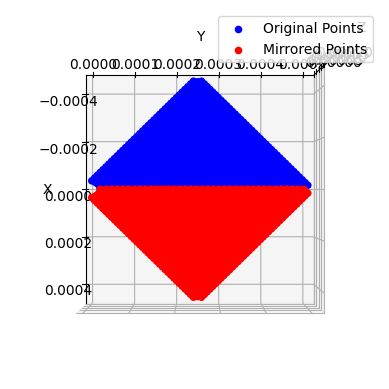

In [4]:
# Plotting the results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot original points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='b', label='Original Points')

# Plot mirrored points
ax.scatter(mirrored_points[:, 0], mirrored_points[:, 1], mirrored_points[:, 2], color='r', label='Mirrored Points')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

ax.view_init(elev=90, azim=0, roll=0)

plt.show()

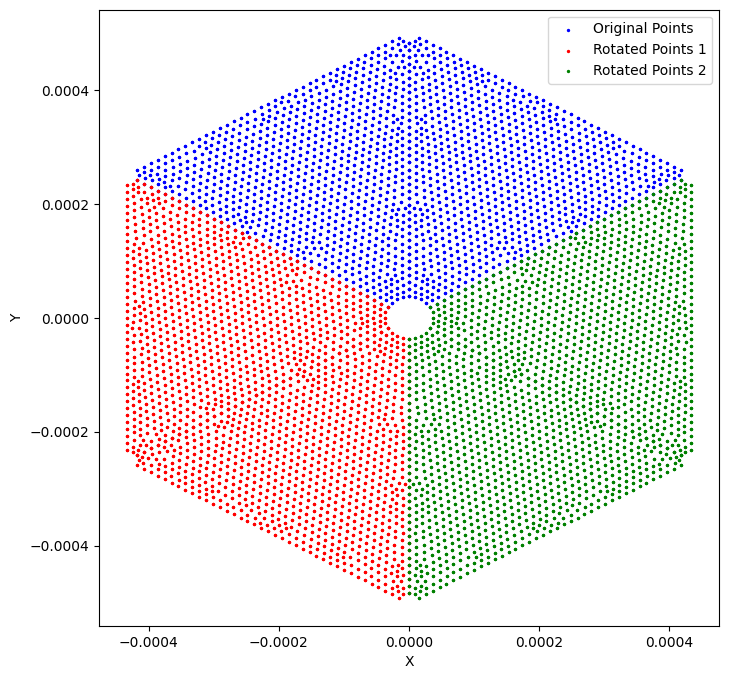

In [5]:
# Plotting the results
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plot original points
ax.scatter(third_points_0[:, 0], third_points_0[:, 1], color='b', s=2, label='Original Points')

# Plot rot points
ax.scatter(third_points_1[:, 0], third_points_1[:, 1], color='r', s=2, label='Rotated Points 1')

# Plot rot points
ax.scatter(third_points_2[:, 0], third_points_2[:, 1], color='g', s=2, label='Rotated Points 2')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()

plt.show()

In [6]:
def remove_duplicate_points(points, cells):
    tree = KDTree(points)
    unique_points, indices = np.unique(tree.query(points, k=1)[1], return_index=True)
    new_points = points[indices]

    # Update cells to point to the new indices
    new_cells = []
    for cell_block in cells:
        cell_type = cell_block.type
        cell_data = cell_block.data
        new_cell_data = np.array([[np.where(indices == point_idx)[0][0] for point_idx in cell] for cell in cell_data])
        new_cells.append(meshio.CellBlock(cell_type, new_cell_data))

    return new_points, new_cells

# Reflect and rotate cells
def transform_cells(cells, point_offset):
    new_cells = []
    for cell_block in cells:
        cell_type = cell_block.type
        cell_data = cell_block.data
        new_cell_data = cell_data + point_offset
        new_cells.append(meshio.CellBlock(cell_type, new_cell_data))
    return new_cells

In [7]:
mirrored_cells = transform_cells(cells, len(points))
rot_cells_1 = transform_cells(mirrored_cells, len(third_points_0))
rot_cells_2 = transform_cells(mirrored_cells, len(third_points_0) * 2)

# Concatenate all cells
all_cells = []
for i, cell_block in enumerate(cells):
    cell_type = cell_block.type
    cell_data = cell_block.data
    new_cell_data = np.concatenate([
        cell_data, 
        mirrored_cells[i].data, 
        rot_cells_1[i].data, 
        rot_cells_2[i].data
    ])
    all_cells.append(meshio.CellBlock(cell_type, new_cell_data))
    
# Remove duplicate points and update cells
full_circle_points, all_cells = remove_duplicate_points(full_circle_points, all_cells)

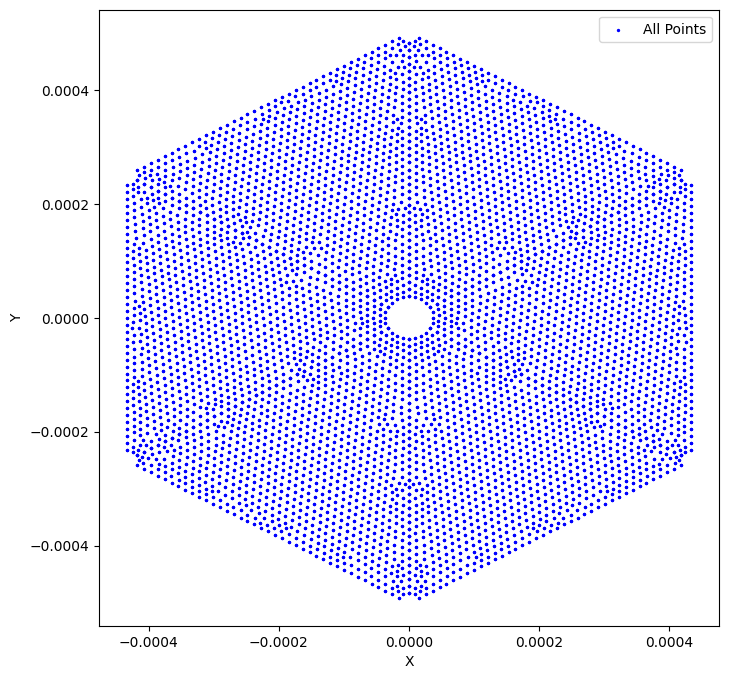

In [8]:
# Plotting the results
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plot original points
ax.scatter(full_circle_points[:, 0], full_circle_points[:, 1], color='b', s=2, label='All Points')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()

plt.show()

TypeError: cannot unpack non-iterable CellBlock object

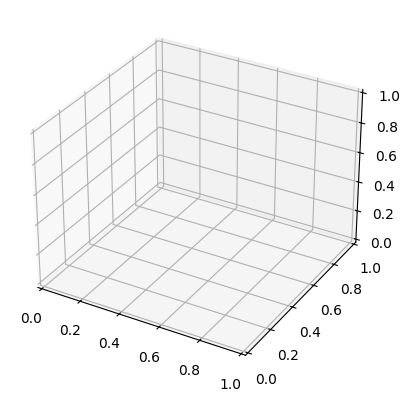

In [9]:
import meshio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Function to plot cells
def plot_cells(cells):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for cell_type, cell_data in cells:
        if cell_type == 'triangle':
            for cell in cell_data:
                verts = [mesh.points[point_index] for point_index in cell]
                ax.add_collection3d(Poly3DCollection([verts], edgecolors='k', linewidths=0.5, alpha=0.5))
        elif cell_type == 'quad':
            for cell in cell_data:
                verts = [mesh.points[point_index] for point_index in cell]
                ax.add_collection3d(Poly3DCollection([verts], edgecolors='k', linewidths=0.5, alpha=0.5))
        elif cell_type == 'tetra':
            for cell in cell_data:
                verts = [mesh.points[point_index] for point_index in cell]
                ax.add_collection3d(Poly3DCollection([verts], edgecolors='k', linewidths=0.5, alpha=0.5))
        elif cell_type == 'hexahedron':
            for cell in cell_data:
                verts = [mesh.points[point_index] for point_index in cell]
                ax.add_collection3d(Poly3DCollection([verts], edgecolors='k', linewidths=0.5, alpha=0.5))
        elif cell_type == 'wedge':
            for cell in cell_data:
                verts = [mesh.points[point_index] for point_index in cell]
                ax.add_collection3d(Poly3DCollection([verts], edgecolors='k', linewidths=0.5, alpha=0.5))
        else:
            print(f"Cell type {cell_type} not supported for plotting.")

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Mesh Cells')
    ax.auto_scale_xyz([-1, 1], [-1, 1], [-1, 1])  # Adjust axis scaling if necessary
    plt.show()

# Example usage
plot_cells(all_cells)